<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Цель" data-toc-modified-id="Цель-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Цель</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#План-действий" data-toc-modified-id="План-действий-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>План действий</a></span></li></ul></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Поиск-модели-ML" data-toc-modified-id="Поиск-модели-ML-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Поиск модели ML</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Поиск оптимальной модели ML для определения рыночной стоимости автомобиля

### Цель

Используя данные автмобильных продаж за несколько лет, найти оптимальную по скорости работы и точности предсказания модель ML. Это поможет сервису по продаже автомобилей с пробегом создать новое приложение и привлечь новых клиентов.

### Описание данных

Датасет содержит данные за 2г. по 350тыс. объектам.

__Признаки__:

`DateCrawled` — дата скачивания анкеты из базы  
`VehicleType` — тип автомобильного кузова  
`RegistrationYear` — год регистрации автомобиля  
`Gearbox` — тип коробки передач  
`Power` — мощность (л. с.)  
`Model` — модель автомобиля  
`Kilometer` — пробег (км)  
`RegistrationMonth` — месяц регистрации автомобиля  
`FuelType` — тип топлива  
`Brand` — марка автомобиля  
`NotRepaired` — была машина в ремонте или нет  
`DateCreated` — дата создания анкеты  
`NumberOfPictures` — количество фотографий автомобиля  
`PostalCode` — почтовый индекс владельца анкеты (пользователя)  
`LastSeen` — дата последней активности пользователя  

__Целевой признак__:  
`Price` — цена (в евро)

### План действий

- загрузка необходимых библиотек и данных
- обзор и пребодработка данных (пропуски, аномалии, дубликаты)
- EDA
- сравнение нескольких моделей ML
- вывод

## Обзор данных

In [1]:
#!pip3 install catboost -U
#!pip3 install seaborn --upgrade -U
#!pip3 install sklearn --upgrade -U

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import PowerTransformer, StandardScaler, QuantileTransformer, OneHotEncoder
import plotly.express as px
from sklearn.manifold import TSNE
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings 
warnings.filterwarnings('ignore')

/home/rudbur/anaconda3/envs/praktikum/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [3]:
try: 
    df = pd.read_csv('datasets/autos.csv', parse_dates=['LastSeen', 'DateCrawled'])
except FileNotFoundError:
    df = pd.read_csv('autos.csv', parse_dates=['LastSeen', 'DateCrawled'])

In [4]:
display(df.shape)
df.head(2)

(354369, 16)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


In [5]:
#преобразование заголовков в snake_case
headers = []
for Header in df.columns:
    headers.append(''.join('_'+c.lower() if c.isupper() else c for c in Header).lstrip('_'))
df.columns = headers

In [6]:
#года размещения объявлений
display(f'Объявления за период: {df.date_created.min()} - {df.date_created.max()}')
display(f'number_of_pictures, уникальные записи: {df.number_of_pictures.unique()[0]}')

'Объявления за период: 2014-03-10 00:00:00 - 2016-04-07 00:00:00'

'number_of_pictures, уникальные записи: 0'

In [7]:
#очистка датасета от ненужных (лишних, не могущих влиять на стоимость автомобиля) признаков
df['month_created'] = pd.DatetimeIndex(df['date_created']).month.astype('object')
df.drop(
    ['date_crawled', 'last_seen', 'number_of_pictures','registration_month', 'date_created'], 
    inplace=True, errors='ignore', axis=1)

In [8]:
#преобразование категориальных признаков в категориальный тип данных
categorical = df.select_dtypes('object').columns.to_list()
numerical = df.columns.difference(categorical).drop('price', errors='ignore')

df[categorical]=df[categorical].astype('category')

In [9]:
#оставим в датасете только объекты с непропущенным значением model и суммарным количеством пропусков < 4
#отобразим долю оставшихся пропусков
#заметим, что целевой признак без пропусков
df=df[(df.isna().sum(axis=1)<4) & (df['model'].notna())]
df.isna().mean()[~df.notna().all()].round(2)

vehicle_type    0.08
gearbox         0.04
fuel_type       0.07
not_repaired    0.18
dtype: float64

In [10]:
#доля дубликатов и их удаление
display(f'duplicates ratio: {df.duplicated().mean():.1%}')
df.drop_duplicates(inplace=True)

'duplicates ratio: 6.2%'

In [11]:
df.nunique()

price                3653
vehicle_type            8
registration_year     117
gearbox                 2
power                 682
model                 250
kilometer              13
fuel_type               7
brand                  39
not_repaired            2
postal_code          8128
month_created           9
dtype: int64

In [12]:
#gasoline == petrol == бензин
display(df.fuel_type.unique(), df.vehicle_type.unique())
df.loc[df.fuel_type == 'gasoline', 'fuel_type'] = 'petrol'

['petrol', 'gasoline', NaN, 'lpg', 'other', 'hybrid', 'cng', 'electric']
Categories (7, object): ['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol']

[NaN, 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'coupe', 'other']
Categories (8, object): ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']

In [13]:
#заполнение пропусков в нескольких категориальных признаках.
#группируем по году выпуска и модели автомобиля, находим моду и ей заполняем пропуски. если мод несколько
#или мода отсутствует - оставляем пропуски в группе без изменений. 
#повторяем операцию с группировкой только по модели

columns_to_fillna = ['vehicle_type','gearbox','fuel_type','not_repaired']

_ = (
    df.groupby(['registration_year', 'model'])[columns_to_fillna]
    .transform(lambda x: x.fillna(x.mode()[0]) if len(x.mode()) == 1 else x)
)
df[columns_to_fillna] = _

_ = (
    df.groupby('model')[columns_to_fillna]
    .transform(lambda x: x.fillna(x.mode()[0]) if len(x.mode()) == 1 else x)
)
df[columns_to_fillna] = _

del _

In [14]:
df.isna().sum()

price                0
vehicle_type         5
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
not_repaired         4
postal_code          0
month_created        0
dtype: int64

In [15]:
#удалим оставшиеся пропуски
df.dropna(inplace=True)

In [16]:
df.shape

(310185, 12)

### Вывод

- датасет на входе содержит около 350тыс. объектов, 16 признаков (включая целевой)
- данные собраны за период 2014 - 2016гг.
- часть объектов и признаков удалили, т.к. они содержали пропуски, дублировали другие объекты, или просто оказались нерелевантными
- пропуски в категориальных признаках заменены модой по группе __модель и год регистрации автомобиля__
- датасет на выходе 310тыс. объектов и 12 признаков (включая целевой) числового и категориального типов

## EDA

In [17]:
#популярность марки
brand_ratio = df.groupby('brand').agg('count').price.sort_values(ascending=False)/len(df)*100
brand_ratio.name = 'ratio'

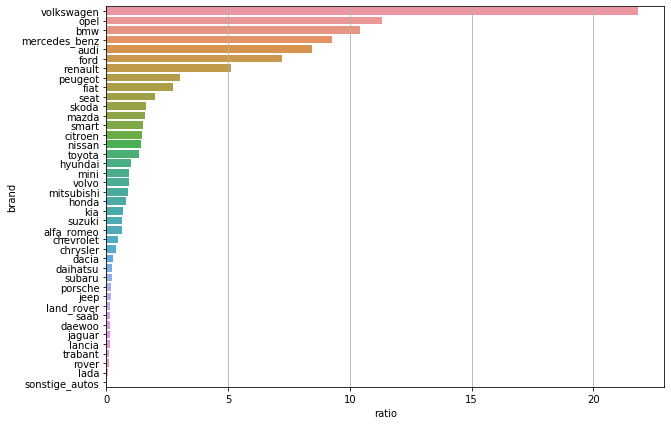

In [18]:
plt.figure(figsize=(10,7))
plt.grid()
sns.barplot(x=brand_ratio, y=brand_ratio.index.astype(str))

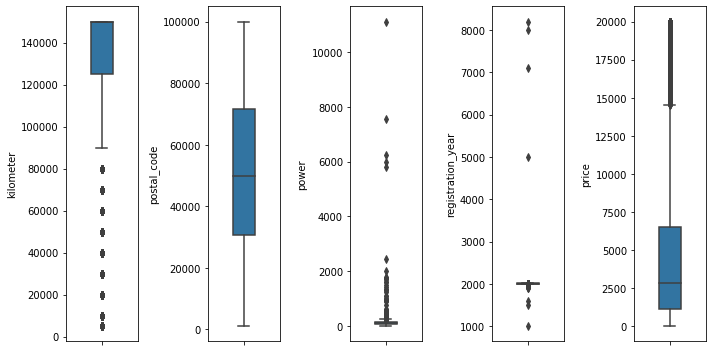

In [19]:
#numerical features with outliers
fig, axes = plt.subplots(1,len(numerical)+1, figsize=(10,5))

for name, ax in zip(numerical.to_list()+['price'], axes.flatten()):
    sns.boxplot(y=df[name].sample(frac=.1), orient='v', ax=ax, width = .3)
fig.tight_layout()

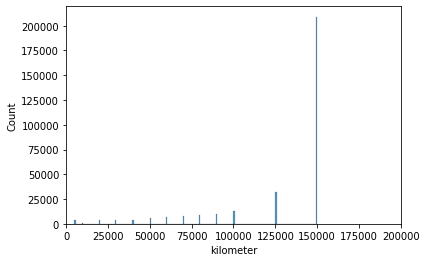

In [20]:
#распределения численных и целевого признаков
plt.xlim(0,200000)
sns.histplot(df.kilometer)

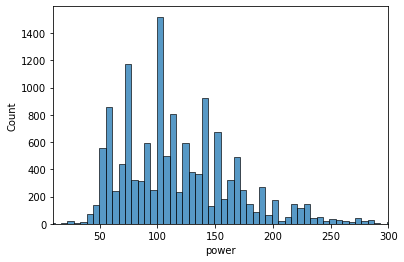

In [21]:
plt.xlim(10,300)
sns.histplot(df.power.sample(frac=.05))

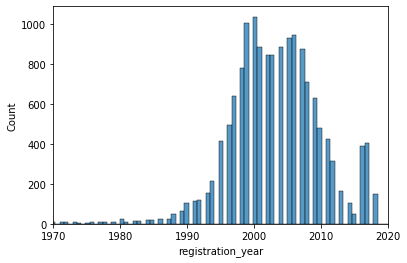

In [22]:
plt.xlim(1970,2020)
sns.histplot(df.registration_year.sample(frac=.05))

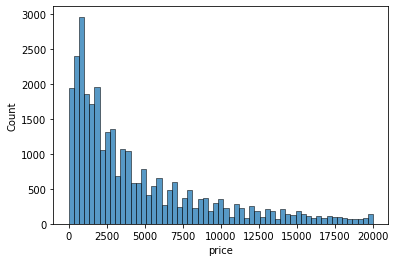

In [23]:
sns.histplot(df.price.sample(frac=.1))

In [24]:
#корреляция признаков
df[numerical.to_list()+['price']].corr().round(2)

,kilometer,postal_code,power,registration_year,price
kilometer,1.00,-0.02,0.02,-0.06,-0.36
postal_code,-0.02,1.00,0.02,0.00,0.08
power,0.02,0.02,1.00,0.01,0.15
registration_year,-0.06,0.00,0.01,1.00,0.06
price,-0.36,0.08,0.15,0.06,1.00


In [25]:
#очистим датасет он неправдободобных значений признаков (цена, год регистрации, мощность)
POWER = {'min':10, 'max':1000}
YEAR = {'min':1900, 'max':2020}
PRICE = {'min':10, 'max':df.power.max()}

filter_power = df.power.between(POWER['min'], POWER['max'])
filter_year = df.registration_year.between(YEAR['min'], YEAR['max'])
filter_price = df.price.between(PRICE['min'], PRICE['max'])
filter_all = filter_power&filter_year&filter_price

In [26]:
df = df[filter_all]

### Вывод

- автомобильные марки представлены сильно неравномерно
- числовые признаки содержат outliers. Очистка датасета от них может улучшить качество моделей.
- автомобили с пробегом > 150тыс.км. в датасете не представлены
- слабая отрицательная корреляция пробега с ценой

## Поиск модели ML

In [27]:
#некоторые модели умеют работать с признаками категориального типа, другим нужен OHE
y = df.price
X = df.drop('price', errors='ignore', axis=1).copy()
X_= pd.get_dummies(X, columns=categorical, drop_first=True)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
X_train_, X_test_ = train_test_split(X_, test_size=.25, random_state=42)

In [29]:
#инициализируем модели с гиперпараметри по умолчанию (кроме cat, у которого уменьшим число итераций)
linear = LinearRegression()
tree = DecisionTreeRegressor(random_state=42)
hist = HistGradientBoostingRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42, n_jobs=-1)
cat = CatBoostRegressor(verbose=False, cat_features=categorical, iterations=100, random_state=42)

estimators = {'linear':linear, 'tree':tree, 'hist':hist, 'lgbm':lgbm, 'cat':cat}

In [30]:
%%time 
#ячейка выполняется ~2мин на 2ух ядрах
#измерим RMSE и время обучения/предсказания моделей 
#увидим быструю и наиболее точную работу LGBM. Cat предсказывает мгновенно и тоже точно, 
#однако т.к. далее мы будем искать перебором лучшие гиперпараметры, 
#то предпочтём LGBM в условиях ограниченных мощностей.

scoring='neg_root_mean_squared_error'

display(f'estimator | RMSE | time_fit | time_pred',)
for _ in estimators.keys():
    if _ in ['lgbm', 'cat']:
        xtrain = X_train
        xtest = X_test
    else:
        xtrain = X_train_
        xtest = X_test_
    start_fit = time()
    estimators[_].fit(xtrain, y_train)
    end_fit = time()
    start_pred = time()
    estimators[_].predict(xtest)
    end_pred = time()
    rmse = cross_val_score(
        estimators[_], xtest, y_test, scoring=scoring, cv=3, n_jobs=-1).mean().__int__().__abs__()
    clock_fit = end_fit - start_fit
    clock_pred = end_pred - start_pred
    display(f'{_:<10}|{rmse:^6}|{clock_fit:^10,.1f}|{clock_pred:>10,.2f}')
del xtrain, xtest, X_

'estimator | RMSE | time_fit | time_pred'

'linear    | 2766 |   13.9   |      0.20'

'tree      | 2354 |   13.3   |      0.21'

'hist      | 1728 |   52.1   |      0.75'

'lgbm      | 1683 |   3.2    |      0.70'

'cat       | 1733 |   9.8    |      0.10'

CPU times: user 3min 30s, sys: 16.1 s, total: 3min 46s
Wall time: 2min 32s


In [31]:
#подберём лучшие гиперпараметры для LGBM и захардкодим их

param_grid = {
    'max_depth': [20], 
    'num_leaves': [60], 
    'learning_rate': [.1], 
    'n_estimators': [400]}

search = RandomizedSearchCV(cv=3, estimator=lgbm, param_distributions=param_grid, scoring=scoring,
    refit=True, return_train_score=False, verbose=10, n_jobs=-1, n_iter=50, random_state=42)

In [32]:
#лучшие гиперпараметры и RMSE
search.fit(X_train, y_train)
display(search.best_params_)
cross_val_score(
    search.best_estimator_, X_test, y_test, scoring=scoring, cv=3, n_jobs=-1).mean().__abs__().__int__()

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'num_leaves': 60, 'n_estimators': 400, 'max_depth': 20, 'learning_rate': 0.1}

1652

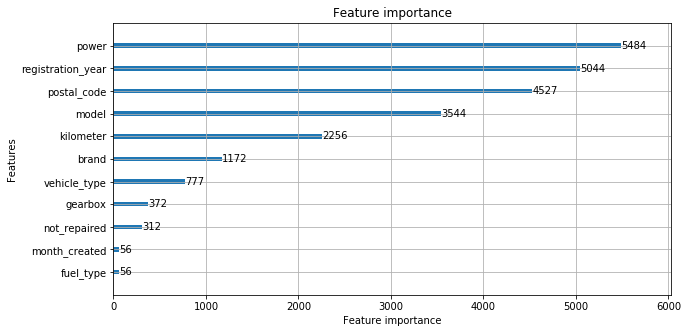

In [33]:
#переобучим модель с лучшими гиперпараметрами на всей выборке
#отобразим важность признаков
best_estimator = search.best_estimator_.fit(X,y)
lgb.plot_importance(best_estimator, figsize=(10,5))

## Вывод

Построенная модель типа LGBM оптимальна по точности (__RMSE=1652__) и скорости предсказания, и скорости обучения. Для создания нового приложения рекомендуем использоваться её.
 
- опробованы несколько разных видов моделей ML
- для всех, кроме LinearRegressor, стандартизация признаков и наличие outliers в датасете почти не влияют на точность предсказания
- марки автомобилей в датасете представлены сильно неравномерно, а пробег - только до 150тыс.км.
- датасет очищен от "плохих" объектов (имеющих много пропусков, дублирующихся или содержащих неправдободобные значения) и "лишних" признаков
- данные собраны за 2014 - 2016гг.